Code from [scale embedding-decoder](https://git.scc.kit.edu/scale/research/embedding-decoder) with slight changes

In [2]:
import tensorflow as tf
import tensorflow_model_analysis as tfma
import random
import networkx as nx
import math
import numpy as np
import matplotlib.pyplot as plt

from util.map import Map
from util.generate_points import list_to_dict, gen_square, gen_disc

In [104]:
args = Map(
    batch_size = 64,
    epochs = 50,
    random_seed = None,
    graph_size = 1000,
    graph_average_degree = 10,
    layers = 10,
    layer_size = 16,
    train_size = 0.7
)

Nodes: 1000
Edges: 5937
Average Degree: 11.874
Largest Component Size: 1000


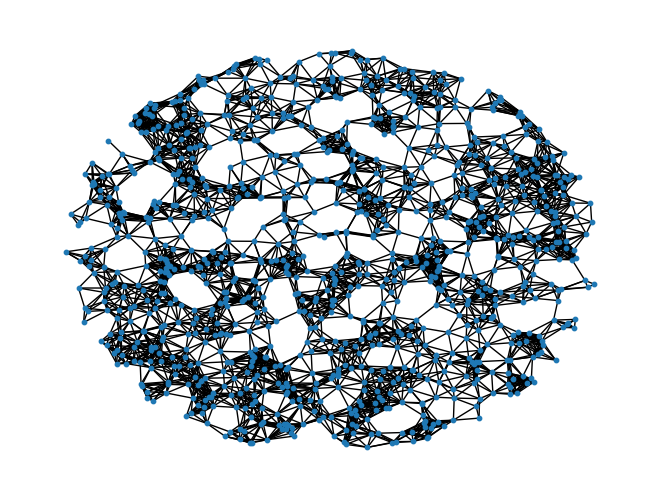

In [105]:
rg_radius = math.sqrt(args.graph_average_degree / (args.graph_size * math.pi))

pos = list_to_dict(gen_disc(args.graph_size))
nx_graph = nx.random_geometric_graph(args.graph_size, rg_radius, pos=pos)  # not based on rng seed yet!
largest_component = max(nx.connected_components(nx_graph), key=len)

print(f'Nodes: {nx_graph.number_of_nodes()}')
print(f'Edges: {nx_graph.number_of_edges()}')
print(f'Average Degree: {2.0 * nx_graph.number_of_edges() / nx_graph.number_of_nodes()}')
print(f'Largest Component Size: {len(largest_component)}')
#pos = nx.circular_layout(nx_graph)
nx.draw(nx_graph, pos, node_size=10)

In [106]:
# tensorflow

# generate dataset from graph. checks and remembers for all pairs of nodes if they were connected by an edge or not.
ds_matracies = []
ds_labels = []
adj = nx.adjacency_matrix(nx_graph)
nodes = nx.nodes(nx_graph)

for x in range(nx_graph.number_of_nodes()):
    for y in range(nx_graph.number_of_nodes()):
        ds_matracies.append(sum((nodes[x]['pos'], nodes[y]['pos']), ()))
                              #append (shape(4)) or vstack (shape(2,2))? probably no difference for an AI
        ds_labels.append([1, 0] if nx_graph.has_edge(x, y) else [0, 1])

full_dataset = tf.data.Dataset.from_tensor_slices((ds_matracies, ds_labels)).batch(args.batch_size)
        
# split dataset
full_dataset = full_dataset.shuffle(nx_graph.number_of_nodes())
train_dataset = full_dataset.take(int(args.train_size * nx_graph.number_of_nodes()))
test_dataset = full_dataset.take(int((1 - args.train_size) * nx_graph.number_of_nodes()))

# build model(s)
model_array = [
    tf.keras.layers.InputLayer(input_shape=(4))] #possible TODO get inputshape dynamically

for i in range(args.layers):
    model_array.append(tf.keras.layers.Dense(args.layer_size, activation='relu')) #make size depending of graph dimensionality? Or would that against the idea?

model_array.append(tf.keras.layers.Flatten())
model_array.append(tf.keras.layers.Dense(2, activation='sigmoid'))

dense_model = tf.keras.Sequential(model_array)

dense_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(), # TODO try other loss function
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(thresholds=0),
        tf.keras.metrics.AUC(
            curve="PR"
        ),
        #tfma.metrics.AUCPrecisionRecall()
    ]
)

# train
train_history = dense_model.fit(train_dataset, epochs=args.epochs)

# evaluate
test_loss, test_acc, e1, e2 = dense_model.evaluate(test_dataset, verbose=0)
dense_model.summary()

C:\Users\Paul\AppData\Local\Temp\ipykernel_9492\3871620058.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(nx_graph)


Epoch 1/50
700/700 [==============================] - 2s 1ms/step - loss: 0.1372 - accuracy: 0.9839 - recall_17: 1.0000 - auc_14: 0.9862
Epoch 2/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0439 - accuracy: 0.9886 - recall_17: 1.0000 - auc_14: 0.9982
Epoch 3/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0245 - accuracy: 0.9877 - recall_17: 1.0000 - auc_14: 0.9996
Epoch 4/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0194 - accuracy: 0.9902 - recall_17: 1.0000 - auc_14: 0.9997
Epoch 5/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0189 - accuracy: 0.9917 - recall_17: 1.0000 - auc_14: 0.9997
Epoch 6/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0168 - accuracy: 0.9925 - recall_17: 1.0000 - auc_14: 0.9997
Epoch 7/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0154 - accuracy: 0.9933 - recall_17: 1.0000 - auc_14: 0.9997
Epoch 8/50
700/700 [=====================

In [107]:
pairs = [ (x, y) for x in range(nx_graph.number_of_nodes()) for y in range(nx_graph.number_of_nodes()) ]
predictions = dense_model.predict([sum((nodes[pair[0]]['pos'], nodes[pair[1]]['pos']), ()) for pair in pairs ])

31250/31250 [==============================] - 21s 668us/step


In [108]:
predictions

array([[8.2346821e-01, 1.7671667e-01],
       [3.3207951e-35, 1.0000000e+00],
       [3.3995701e-13, 1.0000000e+00],
       ...,
       [7.0553609e-17, 1.0000000e+00],
       [1.6025009e-06, 9.9999851e-01],
       [8.2357889e-01, 1.7659751e-01]], dtype=float32)

In [113]:
pred_graph = nx.create_empty_copy(nx_graph, with_data=True)
edges = [ pair for pair, prediction in zip(pairs, predictions) if (prediction[0] >= prediction[1]) ] # and (pair[0] != pair[1])
pred_graph.add_edges_from(edges)

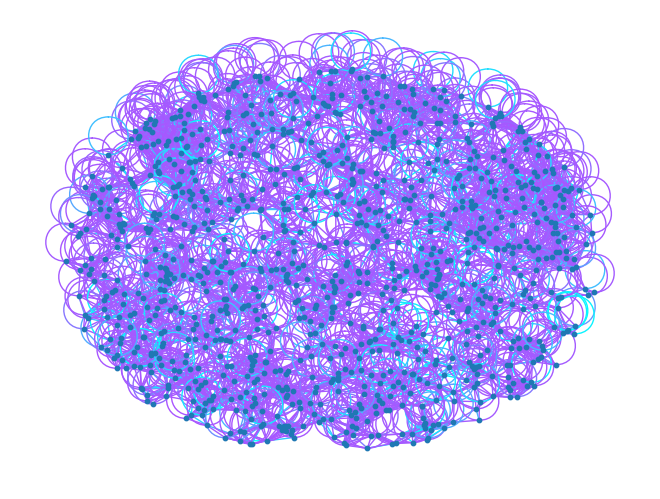

In [114]:
colors = np.array([ (prediction[0] - prediction[1], 1 - (prediction[0] - prediction[1]), 1) for prediction in predictions if (prediction[0] >= prediction[1]) ])
options = {
    #"node_color": "#A0CBE2",
    "edge_color": colors,
    "node_size": 10,
    "edge_cmap": plt.cm.Blues,
    "with_labels": False,
}
nx.draw(pred_graph, pos, **options)